### Packages

In [3]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

### Getting the Data from yFinance

In [4]:
# Getting the current date
from datetime import date
today = date.today()
today

datetime.date(2021, 12, 13)

In [5]:
raw_data = yfinance.download (tickers = "^BSESN ^NSEI ^FTSE ^N225 ^NYA", start = "2008-09-29", end = today,
                              interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  5 of 5 completed


In [10]:
raw_data.tail()

^NYA                                            \
                    Open          High           Low         Close   
Date                                                                 
2021-12-06  16347.870117  16664.300781  16347.870117  16591.970703   
2021-12-07  16591.970703  16918.730469  16591.970703  16853.570312   
2021-12-08  16853.570312  16923.740234  16838.769531  16899.919922   
2021-12-09  16899.919922  16899.919922  16780.410156  16780.470703   
2021-12-10  16780.470703  16888.580078  16762.939453  16856.630859   

                                ^FTSE                                         \
                  Volume         Open         High          Low        Close   
Date                                                                           
2021-12-06  3.305690e+09  7122.299805  7246.299805  7122.299805  7232.299805   
2021-12-07  3.334320e+09  7232.299805  7344.700195  7232.299805  7339.899902   
2021-12-08  3.061550e+09  7339.899902  7378.899902  7333.600098  7337.399902   
2021-12-09  2.851660e+09  7337.100098  7366.100098  7303.000000  7321.299805   
2021-12-10  2.858310e+09  7321.299805  7331.600098  7284.799805  7291.799805   

                         ...         ^NSEI                              \
                 Volume  ...          Open          High           Low   
Date                     ...                                             
2021-12-06  637274000.0  ...  17209.050781  17216.750000  16891.699219   
2021-12-07  783615400.0  ...  17044.099609  17251.650391  16987.750000   
2021-12-08  776663000.0  ...  17315.250000  17484.599609  17308.949219   
2021-12-09  615185100.0  ...  17524.400391  17543.250000  17379.599609   
2021-12-10  533854300.0  ...  17476.050781  17534.349609  17405.250000   

                                           ^N225                              \
                   Close    Volume          Open          High           Low   
Date                                                                           
2021-12-06  16912.250000  231700.0  28069.960938  28081.039062  27693.910156   
2021-12-07  17176.699219  254100.0  28138.820312  28618.460938  27961.660156   
2021-12-08  17469.750000  257800.0  28792.890625  28897.439453  28621.470703   
2021-12-09  17516.849609  237200.0  28827.320312  28908.289062  28725.470703   
2021-12-10  17511.300781  204500.0  28542.500000  28699.009766  28392.869141   

                                      
                   Close      Volume  
Date                                  
2021-12-06  27927.369141  61700000.0  
2021-12-07  28455.599609  78300000.0  
2021-12-08  28860.619141  72000000.0  
2021-12-09  28725.470703  54400000.0  
2021-12-10  28437.769531  63400000.0  

[5 rows x 25 columns]

### Creating the Data

In [6]:
df_comp = raw_data.copy()

In [7]:
df_comp['sensex'] = df_comp['^BSESN'].Close[:]
df_comp['nifty'] = df_comp['^NSEI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]
df_comp['nyse'] = df_comp['^NYA'].Close[:]

In [8]:
df_comp = df_comp.iloc[1:]
del df_comp['^BSESN']
del df_comp['^NSEI']
del df_comp['^FTSE']
del df_comp['^N225']
del df_comp['^NYA']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [9]:
df_comp.tail()

,sensex,nifty,ftse,nikkei,nyse
,,,,,
Date,,,,,
2021-12-06,56747.140625,16912.250000,7232.299805,27927.369141,16591.970703
2021-12-07,57633.648438,17176.699219,7339.899902,28455.599609,16853.570312
2021-12-08,58649.679688,17469.750000,7337.399902,28860.619141,16899.919922
2021-12-09,58807.128906,17516.849609,7321.299805,28725.470703,16780.470703
2021-12-10,58786.671875,17511.300781,7291.799805,28437.769531,16856.630859


### Creating Returns

In [10]:
df_comp['ret_sensex'] = df_comp.sensex.pct_change(1).mul(100)
df_comp['ret_nifty'] = df_comp.nifty.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)
df_comp['ret_nyse'] = df_comp.nyse.pct_change(1).mul(100)

In [11]:
df_comp['norm_ret_sensex'] = df_comp.sensex.div(df_comp.ret_sensex[1])*100
df_comp['norm_ret_nifty'] = df_comp.nifty.div(df_comp.ret_nifty[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100
df_comp['norm_ret_nyse'] = df_comp.ret_nyse.div(df_comp.ret_nyse[1])*100

In [12]:
df_comp.tail()

,sensex,nifty,ftse,nikkei,nyse,ret_sensex,ret_nifty,ret_ftse,ret_nikkei,ret_nyse,norm_ret_sensex,norm_ret_nifty,norm_ret_ftse,norm_ret_nikkei,norm_ret_nyse
,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,
2021-12-06,56747.140625,16912.250000,7232.299805,27927.369141,16591.970703,-1.645370,-1.654092,1.544445,-0.364619,1.493164,3.737921e+06,2.244203e+06,132.602950,-37.874378,-875.334697
2021-12-07,57633.648438,17176.699219,7339.899902,28455.599609,16853.570312,1.562207,1.563655,1.487772,1.891444,1.576664,3.796315e+06,2.279295e+06,127.737083,196.471469,-924.284391
2021-12-08,58649.679688,17469.750000,7337.399902,28860.619141,16899.919922,1.762913,1.706095,-0.034060,1.423339,0.275014,3.863241e+06,2.318182e+06,-2.924359,147.847605,-161.220648
2021-12-09,58807.128906,17516.849609,7321.299805,28725.470703,16780.470703,0.268457,0.269607,-0.219425,-0.468280,-0.706803,3.873612e+06,2.324432e+06,-18.839400,-48.642004,414.347924
2021-12-10,58786.671875,17511.300781,7291.799805,28437.769531,16856.630859,-0.034787,-0.031677,-0.402934,-1.001554,0.453862,3.872265e+06,2.323695e+06,-34.595099,-104.035258,-266.066494


### Splitting the Data

In [13]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [28]:
df_test.head()

,sensex,nifty,ftse,nikkei,nyse,ret_sensex,ret_nifty,ret_ftse,ret_nikkei,ret_nyse,norm_ret_sensex,norm_ret_nifty,norm_ret_ftse,norm_ret_nikkei,norm_ret_nyse
,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,
2019-04-23,38564.878906,11575.950195,7523.100098,22259.740234,12993.849609,-0.207790,-0.159559,0.847199,0.188316,0.616134,2.540260e+06,1.536093e+06,72.738807,19.561093,-361.195247
2019-04-24,39054.679688,11726.150391,7471.799805,22200.000000,12951.629883,1.270070,1.297519,-0.681904,-0.268378,-0.324921,2.572523e+06,1.556024e+06,-58.546880,-27.877441,190.477675
2019-04-25,38730.859375,11641.799805,7434.100098,22307.580078,12912.959961,-0.829146,-0.719337,-0.504560,0.484595,-0.298572,2.551193e+06,1.544831e+06,-43.320504,50.336724,175.031159
2019-04-26,39067.328125,11754.650391,7428.200195,22258.730469,12991.200195,0.868736,0.969357,-0.079363,-0.218982,0.605905,2.573356e+06,1.559806e+06,-6.813922,-22.746506,-355.198267
2019-04-29,39067.328125,11754.650391,7440.700195,22258.730469,13008.059570,0.000000,0.000000,0.168278,0.000000,0.129775,2.573356e+06,1.559806e+06,14.447981,0.000000,-76.077931


### Fitting the Model

### ARMAX

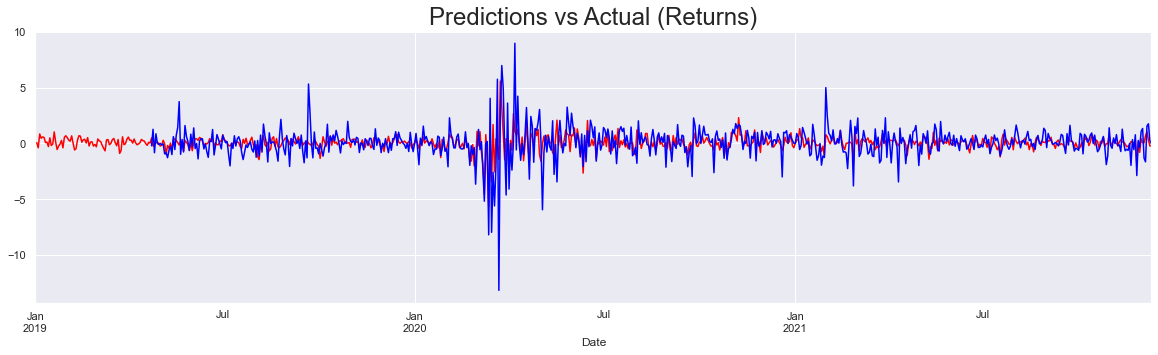

In [23]:
start_date = "2019-01-01"
end_date = "2021-12-10"
model_ret_armax = ARIMA(df.ret_sensex[1:], exog = df[["ret_ftse","ret_nikkei","ret_nyse"]][1:], order = (1,0,1))

results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ret_ftse","ret_nikkei","ret_nyse"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_sensex[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

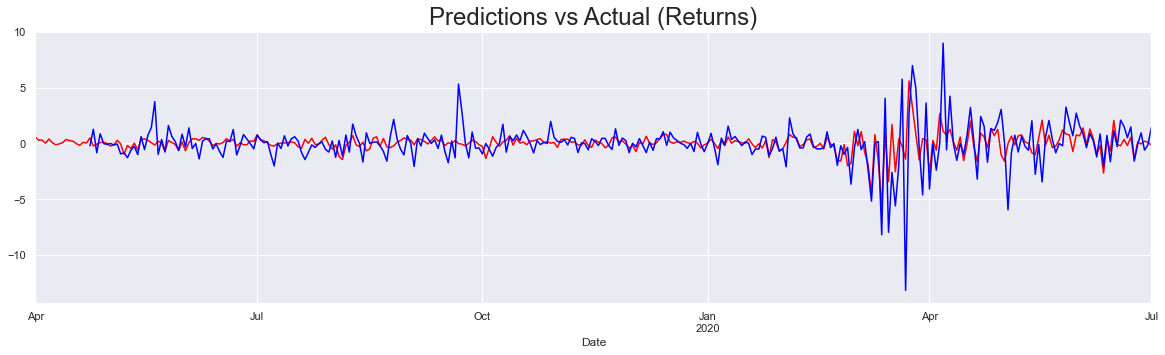

In [27]:
# Lets zoom in a bit

start_date = "2019-04-01"
end_date = "2020-07-01"
model_ret_armax = ARIMA(df.ret_sensex[1:], exog = df[["ret_ftse","ret_nikkei","ret_nyse"]][1:], order = (1,0,1))

results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ret_ftse","ret_nikkei","ret_nyse"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_sensex[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

### SARIMAX

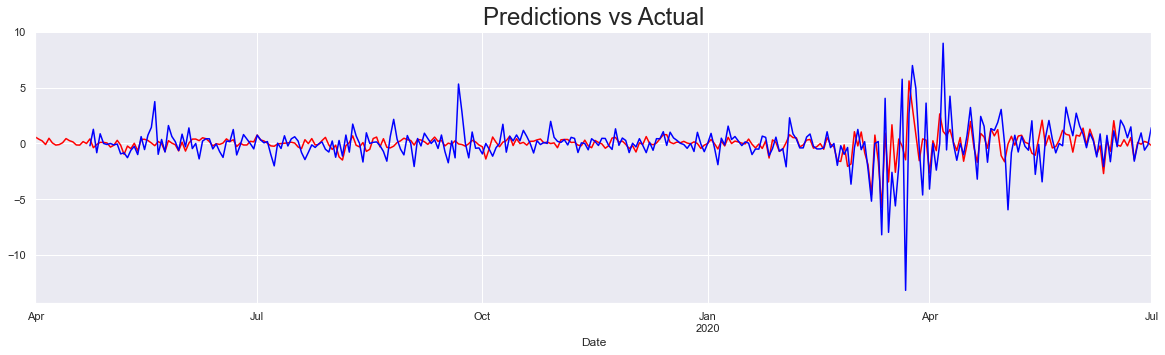

In [29]:
start_date = "2019-04-01"
end_date = "2020-07-01"
model_ret_sarimax = SARIMAX(df.ret_sensex[1:], exog = df[["ret_ftse","ret_nikkei","ret_nyse"]][1:], 
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test[["ret_ftse","ret_nikkei","ret_nyse"]][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_sensex[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Auto ARIMA

In [ ]:
# model_auto = auto_arima(df.ret_sensex[1:], exogenous = df[['ret_ftse','ret_nikkei','ret_nyse']][1:],
#                        m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [ ]:
# df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
#                             exogenous = df_test[['ret_ftse','ret_nikkei','ret_nyse']][start_date:end_date]),
#                             index = df_test[start_date:end_date].index)

In [ ]:
# df_auto_pred.plot(figsize = (20,5), color = "red")
# df_test.ret_sensex[start_date:end_date].plot(color = "blue")
# plt.title("Auto Model Predictions vs Real Data", size = 24)
# plt.show()

### FB Prophet Model for future predictions